<a href="https://colab.research.google.com/github/MarcelDBarbosa/TransferLearning/blob/main/Cavalo_ou_humano.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importação das bibliotecas

In [ ]:
%matplotlib inline

import os
import random
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import keras
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model

#Fazer download do conjunto de dados e descomprimir

In [ ]:
!echo "Abaixando as imagens de cavalos e humanos"
!curl -L -o horse_or_human.zip --progress-bar https://storage.googleapis.com/learning-datasets/horse-or-human.zip
!unzip -q horse_or_human.zip -d /content/img
!rm horse_or_human.zip


#Define o diretório de trabalho, o tamanho dos dados de treino, validação e testes, e mostra as categorias do conjunto de dados

In [ ]:
root = 'img'
train_split, val_split = 0.7, 0.15

categories = [x[0] for x in os.walk(root) if x[0]][1:]


print(categories)

['img/humans', 'img/horses']


#Função para converter a imagem em tamanho compatível com o modelo, além de transformar em um vetor

In [ ]:
def get_image(path):
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

#Cria um vetor com todas as imagens transformadas

In [ ]:
data = []
for c, category in enumerate(categories):
    images = [os.path.join(dp, f) for dp, dn, filenames
              in os.walk(category) for f in filenames
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
    for img_path in images:
        img, x = get_image(img_path)
        data.append({'x':np.array(x[0]), 'y':c})

num_classes = len(categories)

#Reorganiza a ordem das imagens aleatoriamente

In [ ]:
random.shuffle(data)

#Define os dados de treino, validação e testes (70%, 15%, 15%)

In [ ]:
idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))
train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

# Ajusta os dados e as respectivas etiquetas

In [ ]:
x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]

# Normaliza os dados entre 0 e 1 e converte as classes num vetor com tamalho do número de classes. Neste caso serão 2 posições, uma representando cavalo e outra representando humanos. [1,0] ou [0,1]

In [ ]:

x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.


y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_test.shape)

# Resumo dos dados

In [ ]:
# summary
print("Foram carregadas %d imagens de %d categorias"%(len(data), num_classes))
print("Treino / Validação / teste divididos em: %d, %d, %d"%(len(x_train), len(x_val), len(x_test)))
print("Formato dos dados de treinamento: ", x_train.shape)
print("Formato dos rótulos de treinamento: ", y_train.shape)


#Algumas imagens do conjunto de dados

In [ ]:
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
idx = [int(len(images) * random.random()) for i in range(8)]
imgs = [image.load_img(images[i], target_size=(224, 224)) for i in idx]
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)
plt.figure(figsize=(16,4))
plt.imshow(concat_image)

## Transfer learning usando uma rede já treinada

Será usada a rede VGG16 do keras, que foi treinada com os dados ImageNet. Os pesos serão baixados diretamente do keras.

In [ ]:
vgg = keras.applications.VGG16(weights='imagenet', include_top=True)
vgg.summary()



#Para realizar o aprendizado dos novos dados, a camada final de 1000 neurônios (número de categorias do ImageNet) será removida e será criada uma nova camada softmax com o número de neurônios igual ao número de categorias do conjunto de dados, neste caso, 2 categorias


In [ ]:
inp = vgg.input
new_classification_layer = Dense(num_classes, activation='softmax')
out = new_classification_layer(vgg.layers[-2].output)
model_new = Model(inp, out)


# Apenas a última camada terá os pesos ajustados, todas as demais ficarão congeladas pelo ajuste do atributo treinable (false para congelar ou true para ajustar)

In [ ]:
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary()

#Efetuando o treinamento

In [ ]:
exit = model_new.fit(x_train, y_train,
                         batch_size=128,
                         epochs=10,
                         validation_data=(x_val, y_val))


#Gráficos da perda e acurácia dos dados de validação

In [ ]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(exit.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(exit.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

#Resultados de acurácia e perda para o conjunto de imagens de teste

In [ ]:
loss, accuracy = model_new.evaluate(x_test, y_test, verbose=0)

print('Perda dos dados de teste:', loss)
print('Acurácia dos dados de teste:', accuracy)

Test loss: 0.18551227450370789
Test accuracy: 0.9677419066429138


#Aqui pode ser usada uma imagem salva no diretório predicao para realizar a inferência da classe pertencente e a probabilidade de certeza

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
É um cavalo, com probabilidade de 0.84


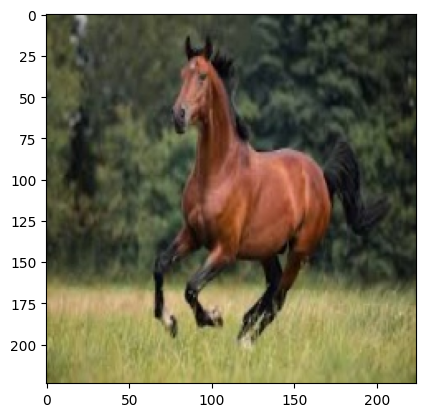

In [ ]:
img, x = get_image('img/predicao/cavalo.jpg')
x = x.astype('float32') / 255.
plt.imshow(img)
probabilities = model_new.predict([x])
if probabilities[0][0] < 0.5:
  print(f'É um cavalo, com probabilidade de {probabilities[0][1]:.2f}')
else:
  print(f'É um humano, com probabilidade de {probabilities[0][0]:.2f}')

